## Introduction
This Notebook contains full comments on the code developed to simulate brewhouse scheduling in Chapter 4 of Andreas Juhl Sørensen's Master's thesis.

For full context, refer to the thesis.

## References
Pyomo guides and documentation can be found at:

[1] Sandia National Laboratories: "Pyomo Documentation 6.8.0", https://pyomo.readthedocs.io/en/stable/#, Date Accessed: 29/10/2024

[2] Bynum, Michael L., et al. “Pyomo — Optimization Modeling in Python.” Pyomo — Optimization Modeling in Python, Springer International Publishing, 2021.

[3] Kanter, Jeffrey C. "ND Pyomo Cookbook", https://jckantor.github.io/ND-Pyomo-Cookbook/README.html, Date Accessed: 29/10/2024

## Prerequisites
This code was developed for Python version 3.12.6 and Pyomo 6.8.0.

In order to simulate the documented example in Python and the Pyomo-extension, the following python packages need to be pre-installed:
1. pyomo
2. matplotlib

These can be installed by running the following commands in a command line (cmd on Windows, terminal on macOS or Linux):

1. pip install pyomo
2. pip install matplotlib

, or the following commands in a Python console of a pre-installed IDE:

1. !pip install pyomo
2. !pip install matplotlib

The following code imports the installed packages mentioned above as well as "numpy", which is built-in for Python distributions.

In [ ]:
# Brewery Case Study - Final Implementation, Representative Example
# MILP Script
# Author: Andreas Juhl Sørensen
# 2024

# %%

#Import PYOMO
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

#Import packages for data and visualisation
import matplotlib.pyplot as plt
import numpy as np

## System Setup
The system is defined based on the STN representation for the brewhouse.

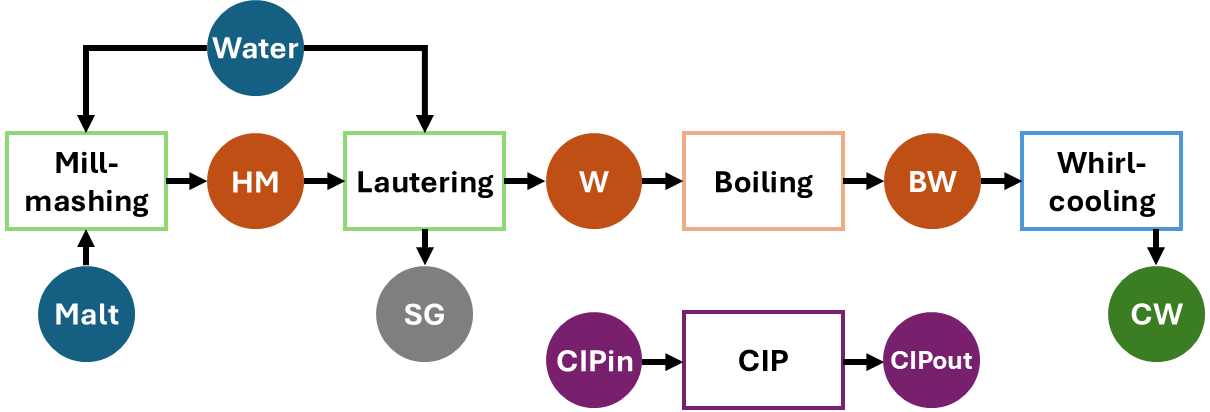

Data relating to these tasks are summarised in the table below (see thesis for full context).

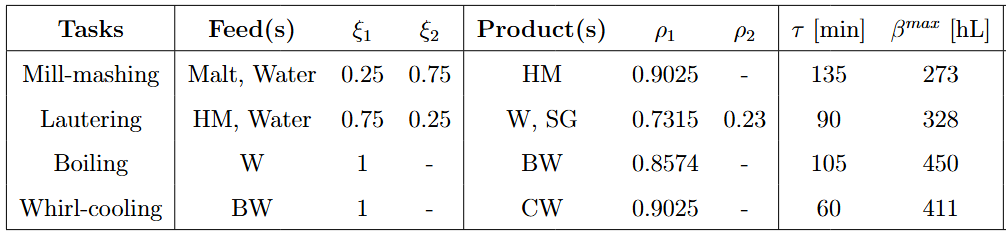

Here, a brewhouse layout with 2 wetmills, 2 mash tuns (for the combined mill-mashing task), 2 lauter tuns, 1 wort kettle, 1 whirlpool and 1 heat exchanger (for the combined whirlcool task) to carry out the above tasks.

The reasoning for the defined capacities and initial inventories can be found in the thesis.

In the code below, this data is stored in dictionaries in a general way, whereas the rest of the code only uses the defined dictionaries, so that if the dictionaries are changed to a different system, the code should still work. The states, units and tasks are stored in the following manner:

In [ ]:
###############################################################################
##DICTIONARIES are created to carry data in a transparent and general manner
#States (as K for material)
K = {
     #General
        'Water':  {'Cap': 100000,'Ini': 100000,'nu':  0},
        'SG':     {'Cap': 10000,'Ini':   0,  'nu':  0},
        'Waste':  {'Cap': 10000,'Ini':   0,  'nu':  0},
        
     #Malt
        'Mp':     {'Cap': 100000,'Ini': 1411.0224,'nu':  0},
        'Mw':     {'Cap': 10000,'Ini': 490.7904,'nu':  0},
        'Ms':     {'Cap': 10000,'Ini': 15.3372,'nu':  0},
        'Mo':     {'Cap': 10000,'Ini': 383.43,'nu':  0},
        
     #Pilsner-specific
        'HMp':    {'Cap': 0,  'Ini':   0,  'nu':  -0.01},
        'Wp':     {'Cap': 510,  'Ini':   0,  'nu':  -0.01},
        'BWp':    {'Cap': 440,  'Ini':   0,  'nu':  -0.01},
        'CWp':    {'Cap': 10000,'Ini':   0,  'nu':  0.03},
        
     #Wheat-specific
        'HMw':    {'Cap': 0,  'Ini':   0,  'nu':  -0.01},
        'Ww':     {'Cap': 510,  'Ini':   0,  'nu':  -0.01},
        'BWw':    {'Cap': 440,  'Ini':   0,  'nu':  -0.01},
        'CWw':    {'Cap': 10000,'Ini':   0,  'nu':  0.03},
        
     #Schwarz-bier
        'HMs':    {'Cap': 0,  'Ini':   0,  'nu':  -0.01},
        'Ws':     {'Cap': 510,  'Ini':   0,  'nu':  -0.01},
        'BWs':    {'Cap': 440,  'Ini':   0,  'nu':  -0.01},
        'CWs':    {'Cap': 10000,'Ini':   0,  'nu':  0.03},
        
     #Organic Pilsner
         'HMo':    {'Cap': 0,  'Ini':   0,  'nu':  -0.01},
         'Wo':     {'Cap': 510,  'Ini':   0,  'nu':  -0.01},
         'BWo':    {'Cap': 440,  'Ini':   0,  'nu':  -0.01},
         'CWo':    {'Cap': 10000,'Ini':   0,  'nu':  0.03},
         
     #CIP
         'CIPin':  {'Cap': 10000,'Ini': 10000,'nu':  0},
         'CIPout': {'Cap': 10000,'Ini':   0,  'nu':  0},
    }

#State-to-Task nodes with feed amount/stoichiometry (as KtI for material to task)
KtI = {
       #Pilsner
        ('Mp',    'MillMashing - P'):   {'xi': 0.25},
        ('Water', 'MillMashing - P'):   {'xi': 0.75},
        ('HMp',   'Lautering - P'):     {'xi': 0.75},
        ('Water', 'Lautering - P'):     {'xi': 0.25},
        ('Wp',    'Boiling - P'):       {'xi': 1.0},
        ('BWp',   'WhirlCooling - P'):  {'xi': 1.0},
        
        #Wheat beer
        ('Mp',  'MillMashing - W'):     {'xi': 0.09},
        ('Mw',  'MillMashing - W'):     {'xi': 0.16},
        ('Water', 'MillMashing - W'):   {'xi': 0.75},
        ('HMw',    'Lautering - W'):    {'xi': 0.75},
        ('Water', 'Lautering - W'):     {'xi': 0.25},
        ('Ww',     'Boiling - W'):      {'xi': 1.0},
        ('BWw',    'WhirlCooling - W'): {'xi': 1.0},
        
        #Schwarz-bier
        ('Mp',  'MillMashing - xS'):   {'xi': 0.235},
        ('Ms',  'MillMashing - xS'):   {'xi': 0.015},
        ('Water', 'MillMashing - xS'): {'xi': 0.75},
        ('HMs',    'Lautering - xS'):     {'xi': 0.75},
        ('Water', 'Lautering - xS'):     {'xi': 0.25},
        ('Ws',     'Boiling - xS'):       {'xi': 1.0},
        ('BWs',    'WhirlCooling - xS'):  {'xi': 1.0},
        
        #Organic
        ('Mo',  'MillMashing - zO'):   {'xi': 0.25},
        ('Water', 'MillMashing - zO'): {'xi': 0.75},
        ('HMo',    'Lautering - zO'):     {'xi': 0.75},
        ('Water', 'Lautering - zO'):     {'xi': 0.25},
        ('Wo',     'Boiling - zO'):       {'xi': 1.0},
        ('BWo',    'WhirlCooling - zO'):  {'xi': 1.0},
        
        #CIP
        ('CIPin', 'aCIP'):           {'xi': 1.0},
    }

#Task-to-State nodes with task processing time and conversion coefficient
ItK = {
       #Pilsner
       ('MillMashing - P', 'HMp'):    {'tau': 135,  'rho': 0.9025},
       ('MillMashing - P', 'Waste'):  {'tau': 135,  'rho': 0.0975},
       ('Lautering - P', 'Wp'):       {'tau': 90,   'rho': 0.7315},
       ('Lautering - P', 'SG'):       {'tau': 90,   'rho': 0.23},
       ('Lautering - P', 'Waste'):    {'tau': 90,   'rho': 0.0385},
       ('Boiling - P', 'BWp') :       {'tau': 105,  'rho': 0.857375},
       ('Boiling - P', 'Waste') :     {'tau': 105,  'rho': 0.142625},
       ('WhirlCooling - P', 'CWp'):   {'tau': 60,   'rho': 0.9025},
       ('WhirlCooling - P', 'Waste'): {'tau': 60,   'rho': 0.0975},
       
       #Wheat beer
        ('MillMashing - W', 'HMw'):    {'tau': 135,  'rho': 0.9025},
        ('MillMashing - W', 'Waste'):  {'tau': 135,  'rho': 0.0975},
        ('Lautering - W', 'Ww'):       {'tau': 90,   'rho': 0.7315},
        ('Lautering - W', 'SG'):       {'tau': 90,   'rho': 0.23},
        ('Lautering - W', 'Waste'):    {'tau': 90,   'rho': 0.0385},
        ('Boiling - W', 'BWw') :       {'tau': 105,  'rho': 0.857375},
        ('Boiling - W', 'Waste') :     {'tau': 105,  'rho': 0.142625},
        ('WhirlCooling - W', 'CWw'):   {'tau': 60,   'rho': 0.9025},
        ('WhirlCooling - W', 'Waste'): {'tau': 60,   'rho': 0.0975},
        
        #Schwarz-bier
         ('MillMashing - xS', 'HMs'):    {'tau': 135,  'rho': 0.9025},
         ('MillMashing - xS', 'Waste'):  {'tau': 135,  'rho': 0.0975},
         ('Lautering - xS', 'Ws'):       {'tau': 90,   'rho': 0.7315},
         ('Lautering - xS', 'SG'):       {'tau': 90,   'rho': 0.23},
         ('Lautering - xS', 'Waste'):    {'tau': 90,   'rho': 0.0385},
         ('Boiling - xS', 'BWs') :       {'tau': 105,'rho': 0.857375},
         ('Boiling - xS', 'Waste') :     {'tau': 105,'rho': 0.142625},
         ('WhirlCooling - xS', 'CWs'):   {'tau': 60, 'rho': 0.9025},
         ('WhirlCooling - xS', 'Waste'): {'tau': 60, 'rho': 0.0975},
         
         #Organic
          ('MillMashing - zO', 'HMo'):    {'tau': 135,  'rho': 0.9025},
          ('MillMashing - zO', 'Waste'):  {'tau': 135,  'rho': 0.0975},
          ('Lautering - zO', 'Wo'):       {'tau': 90,   'rho': 0.7315},
          ('Lautering - zO', 'SG'):       {'tau': 90,   'rho': 0.23},
          ('Lautering - zO', 'Waste'):    {'tau': 90,   'rho': 0.0385},
          ('Boiling - zO', 'BWo') :       {'tau': 105,  'rho': 0.857375},
          ('Boiling - zO', 'Waste') :     {'tau': 105,  'rho': 0.142625},
          ('WhirlCooling - zO', 'CWo'):   {'tau': 60,   'rho': 0.9025},
          ('WhirlCooling - zO', 'Waste'): {'tau': 60,   'rho': 0.0975},
          
          #CIP
          ('aCIP', 'CIPout'):          {'tau': 90,   'rho': 1},
    }

#Units able to perform specific tasks node (as JI_union) with capacity
#and gamma of performing task
JI_union = {
        #Pilsner
        ('MillMash 1', 'MillMashing - P'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('MillMash 2', 'MillMashing - P'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 1', 'Lautering - P'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 2', 'Lautering - P'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Wort Kettle', 'Boiling - P'):      {'Betamin': 1, 'Betamax': 450, 'gamma': 0.01, 'etamax':3,'theta':1},
        ('WhirlCool', 'WhirlCooling - P'):   {'Betamin': 1, 'Betamax': 411, 'gamma': 0.01, 'etamax':3,'theta':1},
        
        #Wheat beer
        ('MillMash 1', 'MillMashing - W'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('MillMash 2', 'MillMashing - W'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 1', 'Lautering - W'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 2', 'Lautering - W'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Wort Kettle', 'Boiling - W'):      {'Betamin': 1, 'Betamax': 450, 'gamma': 0.01, 'etamax':3,'theta':1},
        ('WhirlCool', 'WhirlCooling - W'):   {'Betamin': 1, 'Betamax': 411, 'gamma': 0.01, 'etamax':3,'theta':1},
        
        #Schwarz-bier
        ('MillMash 1', 'MillMashing - xS'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('MillMash 2', 'MillMashing - xS'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 1', 'Lautering - xS'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 2', 'Lautering - xS'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Wort Kettle', 'Boiling - xS'):      {'Betamin': 1, 'Betamax': 450, 'gamma': 0.01, 'etamax':3,'theta':1},
        ('WhirlCool', 'WhirlCooling - xS'):   {'Betamin': 1, 'Betamax': 411, 'gamma': 0.01, 'etamax':3,'theta':1},
        
        #Organic
        ('MillMash 1', 'MillMashing - zO'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('MillMash 2', 'MillMashing - zO'):   {'Betamin': 1, 'Betamax': 273, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 1', 'Lautering - zO'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Lauter Tun 2', 'Lautering - zO'):   {'Betamin': 1, 'Betamax': 328, 'gamma': 0.01, 'etamax':30,'theta':1},
        ('Wort Kettle', 'Boiling - zO'):      {'Betamin': 1, 'Betamax': 450, 'gamma': 0.01, 'etamax':3,'theta':1},
        ('WhirlCool', 'WhirlCooling - zO'):   {'Betamin': 1, 'Betamax': 411, 'gamma': 0.01, 'etamax':3,'theta':1},
        
        #CIP
        ('MillMash 1', 'aCIP'):             {'Betamin': 1, 'Betamax': 1,  'gamma': 0.01, 'etamax':30,'theta':0},
        ('MillMash 2', 'aCIP'):               {'Betamin': 1, 'Betamax': 1,  'gamma': 0.01, 'etamax':30,'theta':0},
        ('Lauter Tun 1', 'aCIP'):             {'Betamin': 1, 'Betamax': 1,  'gamma': 0.01, 'etamax':30,'theta':0},
        ('Lauter Tun 2', 'aCIP'):               {'Betamin': 1, 'Betamax': 1,  'gamma': 0.01, 'etamax':30,'theta':0},
        ('Wort Kettle', 'aCIP'):             {'Betamin': 1, 'Betamax': 1,  'gamma': 0.01, 'etamax':3,'theta':0},
        ('WhirlCool', 'aCIP'):               {'Betamin': 1, 'Betamax': 1,  'gamma': 0.01, 'etamax':3,'theta':0},
    }   
###############################################################################

## System Initialisation

Using the dictionaries, relevant sets are defined in a general manner.

### Definition of states

In [ ]:
###############################################################################

##STATES

#Tasks producing material k
Iplus = {k: set() for k in K}
for (i,k) in ItK:
    Iplus[k].add(i)

#Tasks consuming material k
Iminus = {k: set() for k in K}
for (k,i) in KtI:
    Iminus[k].add(i)

#Storage capacity/maximum inventory of material k
Sk_max = {k: K[k]['Cap'] for k in K}

###############################################################################

### Definition of tasks

In [ ]:
###############################################################################

##TASKS

#All tasks in a set
I = set([i for (j,i) in JI_union])

#Materials that are produced by task i
Kplus = {i: set() for i in I}
for (i,k) in ItK:
    Kplus[i].add(k)

#Materials that are consumed by task i
Kminus = {i: set() for i in I}
for (k,i) in KtI:
    Kminus[i].add(k)

#Input fraction (xi) of task i from material k
xi = {(i,k): KtI[(k,i)]['xi'] for (k,i) in KtI}

#Output fraction (conversion coefficient) of task i to material k
rho = {(i,k): ItK[(i,k)]['rho'] for (i,k) in ItK}

#Time to release of material k from task i (tauK), and task processing time (tau)
tauK = {(i,k): ItK[(i,k)]['tau'] for (i,k) in ItK}
tau = {i: max([tauK[(i,k)] for k in Kplus[i]]) for i in I}

#Units capable of task i
Ji = {i: set() for i in I}
for (j,i) in JI_union:
    Ji[i].add(j)

###############################################################################

### Definition of units

In [ ]:
###############################################################################

##UNITS

#All units in a set
J = set([j for (j,i) in JI_union])

#Tasks able to be carried out in unit j
Ij = {j: set() for j in J}
for (j,i) in JI_union:
    Ij[j].add(i)
    
#Minimum and maximum capacity
Betamin = {(i,j):JI_union[(j,i)]['Betamin'] for (j,i) in JI_union}
Betamax = {(i,j):JI_union[(j,i)]['Betamax'] for (j,i) in JI_union}

###############################################################################

## Setting up a PYOMO Model
In the following code the model is set up in Pyomo by setting a model of time and defining overall variables.

The time is modelled for [0,48.5] hours with a time interval of 15 minutes, since 15 minutes is the lowest common factor for transient data.

The variables are $W$, which is a binary/Boolean variable, $B$, $S$ and $M$, which can all take non-negative, real values, all of which is defined in the code below.

Furthermore, the terms in the objective function:
$$
\text{max} \ \sum_{k\in CW} S_k(H) - \sum_{k,t} \nu_k \, S_k(t) - \sum_{i,j,t} \gamma_{ij} \, W_{ij}(t) - \sum_{i,i',j,t} \chi_{ii'j}\, Y_{ii'j}(t)
$$
are defined, except from the last pertaining to changeover costs as this is defined later.

All of the above is defined in the code below.

In [ ]:
###############################################################################

##MODELLING: VARIABLES AND OBJECTIVE

#Create model environment
model = pyo.ConcreteModel()

#Planning horizon (H), time interval (tgap) and time (T)
H = 48.5*60
tgap = 15
T = tgap*np.array(range(0,int(1/tgap*H)+1))

#Decision variable Wijt
model.W = pyo.Var(I,J,T,domain=pyo.Boolean)

#Batch size decision cariable Bijt
model.B = pyo.Var(I,J,T,domain=pyo.NonNegativeReals)

#Lifted variable handling: M is inventory of unit j at time t
model.M = pyo.Var(J, T, domain=pyo.NonNegativeReals)

#Inventory variable
model.S = pyo.Var(K.keys(),T, domain=pyo.NonNegativeReals)

#Cost of operation
model.OpCost = pyo.Var(domain=pyo.NonNegativeReals)
model.OpCostcon = pyo.Constraint(expr = model.OpCost == 
                                 sum([JI_union[(j,i)]['gamma']*model.W[i,j,t] 
                                      for i in I for j in Ji[i] for t in T]))

#Value of inventory
model.SVal = pyo.Var(domain=pyo.NonNegativeReals)
model.SValcon = pyo.Constraint(expr = model.SVal == sum([K[k]['nu']*model.S[k,t] for k in K for t in T]))

#Throughput
model.Prod = pyo.Var(domain=pyo.NonNegativeReals)
model.Prodcon = pyo.Constraint(expr = model.Prod == 
                               model.S['CWp',H] + model.S['CWw',H] 
                               + model.S['CWs',H] + model.S['CWo',H])

#Objective defined later with the introduction of changeover variables

###############################################################################

Both equations and constraints can be easily handled through Pyomo's constraint environment.

The constraints for the overall variables are:
1. For $W$, only one task can run on a unit at a time:
$$
\sum_{i\, \in\, \textbf{I}_{j}} \sum_{n=t}^{t-\tau_i+1} W_{ij}(n) \leq 1 \quad \quad \forall \ j,\, t
$$
2. For $B$, unit capacity constraint:
$$
\beta_{j}^{min} \, W_{ij}(t) \leq B_{ij}(t) \leq \beta_{j}^{max} \, W_{ij}(t) \quad \quad \forall \ i\, \in \, \textbf{I}_j,\, j,\, t
$$
3. For $S$, maximum inventory/storage capacity constraint:
$$
S_k(t) \leq S_k^{max} \quad \quad \forall \ k,\, t
$$
4. For $M$, which is a terminal constraint so that no unit is active at $t=H$:
$$
M_j(H) = 0 \quad \quad \forall \ j
$$

The equations (discrete time development of variables) are:
1. For $S$, which is essentially a mass balance at each time point:
$$
S_{k}(t+1) = S_{k}(t) + \sum_j \sum_{\substack{i\, \in\, I_{jk}^+ \\ i\, \ni\, t-\bar{\tau}_{ik} \geq 0}} \left(\rho_{ijk}\, B_{ij} (t-\bar{\tau}_{ik})\right) + \sum_j \sum_{i\, \in\, I_{jk}^-} (\rho_{ijk} \, B_{ij}(t)) \quad \quad \forall \ k,\, t
$$
2. For $M$, which is a unit mass balance at each time point:
$$
M_j(t+1) = M_j(t) + \sum_{i\, \in\, \textbf{I}_{j}} B_{ij}(t+1) - \sum_{i\, \in\, \textbf{I}_{j}} \sum_{\substack{k\, \in \, \textbf{K}_i \\ k\, \ni t-\bar{\tau}_{ik}\geq 0}} \rho_{ijk}\, B_{ij}(t-\bar{\tau}_{ik}+1) \quad \quad \forall \ j,\, t
$$
, all of which is implemented in the code below.

In [ ]:
###############################################################################

##MODELLING: EQUATIONS AND CONSTRAINTS

#Create constraint environment
model.con = pyo.ConstraintList()

#Constraint 1: Only one task per unit at time t
for j in J:
    for t in T:
        eq = 0
        for i in Ij[j]:
            for n in T:
                if n >= (t-tau[i]+1) and n <= t:
                    eq = eq + model.W[i,j,n]
        model.con.add(eq <= 1)
        
#Constraint 2: Unit minimum and maximum capacity
for t in T:
    for j in J:
        for i in Ij[j]:
            model.con.add(model.W[i,j,t]*Betamin[i,j] <= model.B[i,j,t])
            model.con.add(model.B[i,j,t] <= model.W[i,j,t]*Betamax[i,j]) 
    
#Constraint 3: Storage capacity/maximum inventory
model.Scon = pyo.Constraint(K.keys(), T, rule = lambda model, k, t: model.S[k,t] <= Sk_max[k])

#Equation 1: Development of inventory over time (Mass balances)
for k in K.keys():
    eq = K[k]['Ini']
    for t in T:
        for i in Iplus[k]:
            for j in Ji[i]:
                if t >= tauK[(i,k)]: 
                    eq = eq + rho[(i,k)]*model.B[i,j,max(T[T <= t-tauK[(i,k)]])]             
        for i in Iminus[k]:
            eq = eq - xi[(i,k)]*sum([model.B[i,j,t] for j in Ji[i]])
        model.con.add(model.S[k,t] == eq)
        eq = model.S[k,t] 

#Equation 2: Development of M over time
for j in J:
    eq = 0
    for t in T:
        eq = eq + sum([model.B[i,j,t] for i in Ij[j]])
        for i in Ij[j]:
                for k in Kplus[i]:
                    if t >= tauK[(i,k)]:
                        eq = eq - rho[(i,k)]*model.B[i,j,max(T[T <= t-tauK[(i,k)]])]
        model.con.add(model.M[j,t] == eq)
        eq = model.M[j,t]

#Additional constraint: No active units at the end of the scheduling horizon
model.tc = pyo.Constraint(J, rule = lambda model, j: model.M[j,H] == 0)

###############################################################################

Then, the equations and variables relating to unit deterioration, CIP and changeovers are introduced.

First, only CIP can only be carried out on a unit at a time:
$$
\sum_{n=t}^{t-\tau_{\text{CIP}}+1} W_{\text{CIP}j}(n) \leq 1 \quad \quad \forall \ j,\, t
$$

$H$ is the residual life of units variable which can take up an integer value up to $\eta_j^{max}$, and is therefore constrained by:
$$
0 \leq H_j(t) \leq \eta_j^{max}
$$
, and its development over time is:
$$
H_j(t) = H_j(t-1) - \sum_{i\in \textbf{I}_j} (\theta_i \, W_{ij}(t)) + H_j^+(t) - H_j^-(t) \quad \quad \forall \ j,\, t \geq 1
$$
Here, the variables $H_j^+(t)$ and $H_j^-(t)$ deal with the restoration and depletion of unit health when certain events occur, and they can in theory take up the same values as $H_j(t)$. $H_j^+(t)$ deals with the restoration of health when CIP is performed on a unit and is constrained by:
$$
H_j^+(t) \leq \eta_j^{max} \, W_{i^Mj}(t) \quad \quad \forall \ j,\,t \\
H_j^+(t) \leq \eta_j^{max} - H_j(t-1) \quad \quad \forall \ j,\, t \geq 1 \\
H_j^+(t) \geq \eta_j^{max} \, W_{i^Mj}(t) - H_j(t-1) \quad \quad \forall \ j,\, t \geq 1
$$
, ensuring that $H_j(t)$ is exactly restored to $\eta_j^{max}$ when CIP on a unit occurs ($i^M$ is a CIP task).
$H_j^-(t)$ deals with the depletion of unit health when a changeover \textbf{from} schwarzbier occurs to ensure cleaning immediately after, and is constrained by:
$$
H_j^-(t) \geq H_j(t-1)-\eta_j^{max}\,(1-Y_{ii'j}(t)) \quad \quad \forall \ i\, \in\, \textbf{I}_{j,\text{SB}},\, i'\, \in\, \textbf{I}_{j},\, j,\, t\geq 1 \\
H_j^-(t) \leq  H_j(t-1)+\eta_j^{max}\,(1-Y_{ii'j}(t)) \quad \quad \forall \ i\, \in\, \textbf{I}_{j,\text{SB}},\, i'\, \in\, \textbf{I}_{j},\, j,\, t\geq 1 \\
H_j^-(t) \geq 0 \quad \quad \forall \ j,\, t \\
H_j^-(t) \leq \eta_j^{max}\,Y_{ii'j}(t) \quad \quad \forall \ i\, \in\, \textbf{I}_{j,\text{SB}},\, i'\, \in\, \textbf{I}_{j},\, j,\, t
$$
, ensuring the desired behaviour. Here, the changeover variable $Y_{ii'j}(t)$ is used, which is a binary variable that is 1 when a change over from task $i$ to task $i'$ in unit $j$ at time $t$. It is defined in tandem with another binary variable $X_{ij}(t)$ which is equal to 1 if unit $j$ is setup to carry out task $i$ at time $t$. They are both included in the development equation:
$$
X_{ij}(t) = X_{ij}(t-1) + \sum_{i' \neq i} Y_{i'ij}(t-1 ) - \sum_{i'\neq i} Y_{ii'j} (t-1) \quad \quad \forall \ i\, \in \, \textbf{I}_j,\, j,\, t\geq 1
$$
, and are constrained by:
$$
\sum_{t'=t-\tau_{ij}}^{t-1} W_{ij}(t') \leq X_{ij}(t) \quad \quad \forall \ i\, \in \, \textbf{I}_j,\, j,\, t \geq \tau_{ij} \\
Y_{iij}(t) = 0 \quad \quad \forall \ i\, \in\, \textbf{I}_j,\, j,\, t
$$
, ensuring the desired behaviour and that $Y_{ii'j}(t) = 0$ when $i=i'$ by definition.
Lastly, the enforcement of CIP before organic pilsner is included through the following constraint:
$$
\eta^{max}_j \,Y_{ii'j}(t) \leq H_j(t) \quad \quad \forall \ i\, \in\, \textbf{I}_j,\, i'\, \in\, \textbf{I}_{j,\text{OP}},\, j,\, t
$$

All of the above equations are implemented below, along with the changeover costs and objective function.

In [ ]:
###############################################################################

##CIP EQUATIONS AND CONSTRAINTS

#Gather maximum health and task health use
etamax = {j:JI_union[(j,i)]['etamax'] for (j,i) in JI_union}
theta = {(j,i):JI_union[(j,i)]['theta'] for (j,i) in JI_union}

#Define health variables
model.H = pyo.Var(J, T, domain=pyo.NonNegativeIntegers)
model.Hp = pyo.Var(J, T, domain=pyo.NonNegativeIntegers)
model.Hm = pyo.Var(J, T, domain=pyo.NonNegativeIntegers)

#Define changeover variables
model.Y = pyo.Var(I,I,J,T, domain=pyo.Boolean)
model.X = pyo.Var(I,J,T, domain=pyo.Boolean)

#Health: Bounds and relationships
for j in J:
    eq = etamax[j]
    for t in T:
        model.con.add(model.H[j,t] <= etamax[j])
        model.con.add(model.H[j,t] >= 0)
        model.con.add(model.Hp[j,t] <= (etamax[j])*model.W['aCIP',j,t])
        model.con.add(model.Hm[j,t] >= 0)
        if t >= tgap:
            model.con.add(model.Hp[j,t] <= etamax[j] - model.H[j,t-tgap])
            model.con.add(model.Hp[j,t] >= (etamax[j])*model.W['aCIP',j,t] - model.H[j,t-tgap])
            for i in Ij[j]:
                if i.endswith('- xS'):
                    for im in Ij[j]:
                        model.con.add(model.Hm[j,t] >= model.H[j,t-tgap] - etamax[j] * (1-model.Y[i,im,j,t]) )
                        model.con.add(model.Hm[j,t] <= model.H[j,t-tgap] + etamax[j] * (1-model.Y[i,im,j,t]) )
                        model.con.add(model.Hm[j,t] <= etamax[j]* model.Y[i,im,j,t])
        eq = eq - sum([model.W[i,j,t]*theta[j,i] for i in Ij[j]]) + model.Hp[j,t] - model.Hm[j,t]
        model.con.add(model.H[j,t] == eq)
        eq = model.H[j,t]

#Changeovers: Bounds and relationships
for j in J:
    for i in Ij[j]:
        if i.endswith('- P'):
            eq = 1
        else:
            eq = 0
        for t in T:
            model.con.add(sum([model.X[iw,j,t] for iw in Ij[j]]) == 1)
            eqY1 = 0
            eqY2 = 0
            if t >= tau[i]:
                model.con.add(sum([model.W[i,j,z] for z in tgap*np.array(range(int((t-tau[i])/tgap),int(t/tgap)))]) <= model.X[i,j,t])
            for im in Ij[j]:
                if i != im and t >= 7*tau['MillMashing - P']-tgap:
                    eqY1 = eqY1 + model.Y[im,i,j,t-tgap]
                    eqY2 = eqY2 + model.Y[i,im,j,t-tgap]
                elif i == im:
                    model.con.add(model.Y[i,im,j,t] == 0)
            eq = eq + eqY1 - eqY2
            model.con.add(model.X[i,j,t] == eq)
            eq = model.X[i,j,t]

#Cleaning before organic pilsner
for j in J:
    for im in Ij[j]:
        if im.endswith('- zO'):
            for t in T[1:]:
                for i in Ij[j]:
                    model.con.add(etamax[j]*model.Y[i,im,j,t] <= model.H[j,t-tgap])

#Only 1 CIP at a time
for t in T:
    eq = 0
    for n in T:
        if n >= (t-tau['aCIP']+1) and n <= t:
            eq = eq + sum([model.W['aCIP',j,n] for j in J])
    model.con.add(eq <= 1)
    
#Changeover costs
model.CO = pyo.Var(domain=pyo.NonNegativeReals)
model.COcon = pyo.Constraint(expr = model.CO == 0.1*sum([model.Y[i,im,j,t] for i in I for im in I for j in Ji[i] for t in T]))

#Objective function defined as maximisation of throughput and minimisation of changeovers
model.obj = pyo.Objective(expr = model.Prod + model.SVal - model.OpCost - model.CO, sense = pyo.maximize)

###############################################################################

## Solving the Pyomo Model
To solve the Pyomo model, it is necessary to have access to a supported solver. Supported solvers can be found in the Pyomo documentation (https://pyomo.readthedocs.io/en/6.8.0/solving_pyomo_models.html).

For this work, the commercial solver CPLEX by IBM was used, which is licensed but free for students and people affiliated with universities. 

For installation refer to the download link https://community.ibm.com/community/user/ai-datascience/blogs/xavier-nodet1/2020/07/09/cplex-free-for-students and the CPLEX for Pyomo guide in https://or.stackexchange.com/questions/4366/downloading-and-setting-up-cplex-for-pyomo.

Other open-source solvers are available and can be installed in a similar manner.
The Pyomo model is solved in the following code, and a different solver can simply be implemented by replacing the 'cplex' entry.

Here, the optimality gap and a maximum time limit (in seconds) for the simulation is also defined.

In [ ]:
###############################################################################

##SOLVE MODEL AND VISUALISE

#Solve the model with PYOMO optimisation
solver = SolverFactory('cplex')
solver.options['mipgap'] = 0.0001
solver.options['timelimit'] = 108000

solver.solve(model,tee=True)

## Visualisation of Solution
The solution is then visualised in a Gantt chart through the following code using the matplotlib package by printing an entry every time $W_{ij}(t)>0$ through the following code:

In [ ]:
#Visualise solution in Gantt chart
plt.figure(figsize=(15,7))

#Gap between bars
bargap = 1/1000*H/60
#Initialisation
marks = []
lbls = []
idp = 1
Jsort = ['MillMash 1','MillMash 2','Lauter Tun 1','Lauter Tun 2','Wort Kettle','WhirlCool']
#Plotting over units and tasks - some formatting is performed for tasks relating to beer types
for j in Jsort:
    idp = idp - 1
    idBeerType = 0
    for i in sorted(Ij[j]):
        idp = idp - 1
        idBeerType = idBeerType + 1
        #Marks and titles
        marks.append(idp)
        if idBeerType == 1:
            lbls.append("{0:s} (P)".format(j))
        elif idBeerType == 2:
            lbls.append("{0:s} (W)".format(j))
        elif idBeerType == 3:
            lbls.append("{0:s} (S)".format(j))
        elif idBeerType == 4:
            lbls.append("{0:s} (O)".format(j))
        elif idBeerType == 5:
            lbls.append("{0:s} (CIP)".format(j))
        for t in T:
            if model.W[i,j,t]() > 0.1:
                #Gantt chart bar
                if idBeerType == 1:
                    plt.plot([t/60+bargap,t/60+tau[i]/60-bargap], [idp,idp],alpha=.5,color='c', lw=15, solid_capstyle='butt')
                elif idBeerType == 2:
                    plt.plot([t/60+bargap,t/60+tau[i]/60-bargap], [idp,idp],alpha=.5,color='m', lw=15, solid_capstyle='butt')
                elif idBeerType == 3:
                    plt.plot([t/60+bargap,t/60+tau[i]/60-bargap], [idp,idp],alpha=.5,color='darkorange', lw=15, solid_capstyle='butt')
                elif idBeerType == 4:
                    plt.plot([t/60+bargap,t/60+tau[i]/60-bargap], [idp,idp],alpha=.5,color='lime', lw=15, solid_capstyle='butt')
                elif idBeerType == 5:
                    plt.plot([t/60+bargap,t/60+tau[i]/60-bargap], [idp,idp],alpha=.5,color='r', lw=15, solid_capstyle='butt')
                #Gantt chart text
                txt = "{0:.0f}".format(model.B[i,j,t]())
                plt.text(t/60+tau[i]/60/2, idp, txt, color='k', weight='bold', ha='center', va='center')
#Axis formatting
plt.xlim(0,H/60)
plt.xlabel("Time [h]", fontweight='bold')
plt.ylabel("Units", fontweight='bold')
plt.gca().set_yticks(marks)
plt.gca().set_yticklabels(lbls);
# %%